In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt

# shunqing

## Prediction

In [55]:
cwd = './results/shunqing/10s_res_norm_roll_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [56]:
event = 'bpswmm_61'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


In [57]:
err.shape

(391, 10, 105, 6)

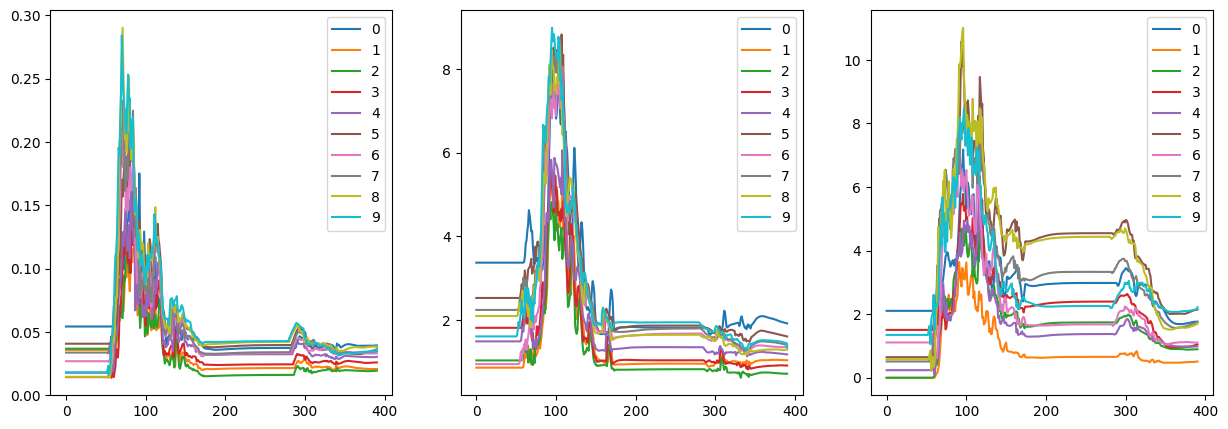

In [58]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

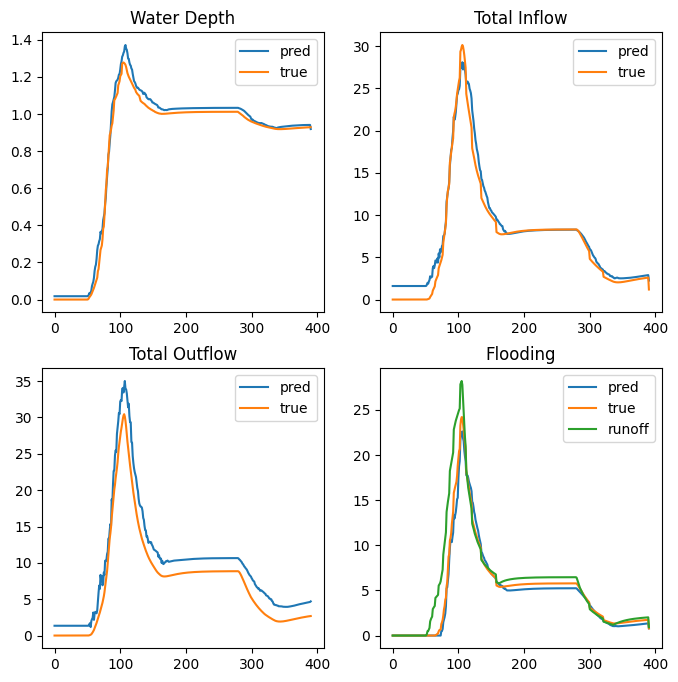

In [59]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

- Select a Node to plot, what is the outlet boundary?
- Cannot predict water level of a specific node precisely
    - Possibly because it depends on both up and downstream
    - Or it can be better if nodes have storage volumes: not significant
    - Water level error makes up with small loss: Normalization works
- Cannot Predict flooding precisely
    - Classify flooding or not: It works!!!

In [46]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in inp.JUNCTIONS]

Text(0.5, 1.0, 'Flooding')

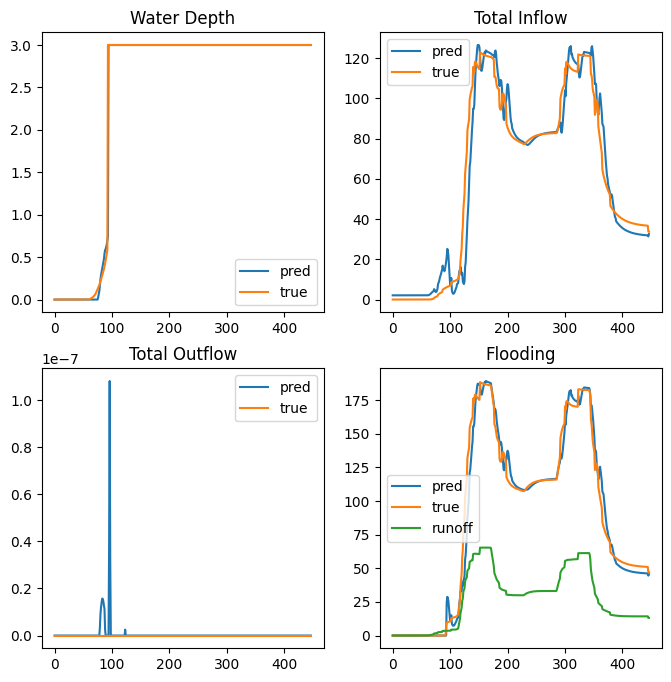

In [50]:
idx = nodes.index('jd35')
seq = 0

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

Text(0.5, 1.0, 'flood prediction')

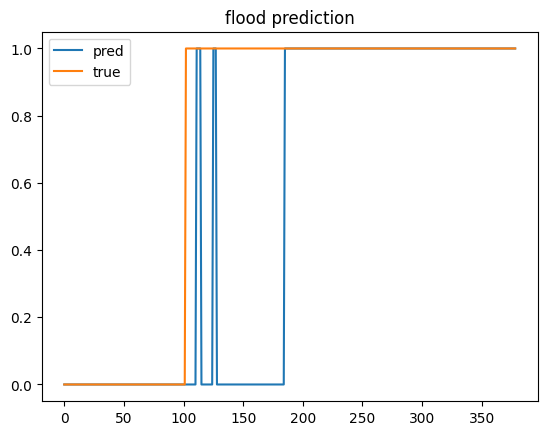

In [35]:
seq = 0

plt.plot(np.argmax(pred[:,seq,...].mean(axis=1)[:,-2:],axis=-1),label='pred')
plt.plot(np.argmax(true[:,seq,...].mean(axis=1)[:,-2:],axis=-1),label='true')
plt.legend()
plt.title('flood prediction')

In [ ]:
hmax = np.array([v.MaxDepth for _,v in inp.JUNCTIONS.items()])

Text(0.5, 1.0, 'flood prediction')

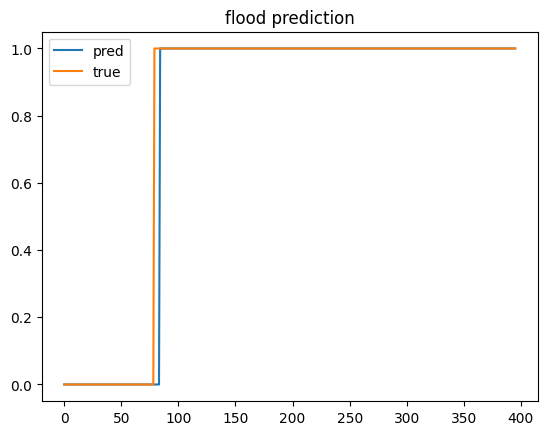

In [48]:
idx = nodes.index('jd28')
seq = -1

plt.plot(np.argmax(pred[:,seq,idx,-2:],axis=-1),label='pred')
plt.plot(np.argmax(true[:,seq,idx,-2:],axis=-1),label='true')
plt.legend()
plt.title('flood prediction')

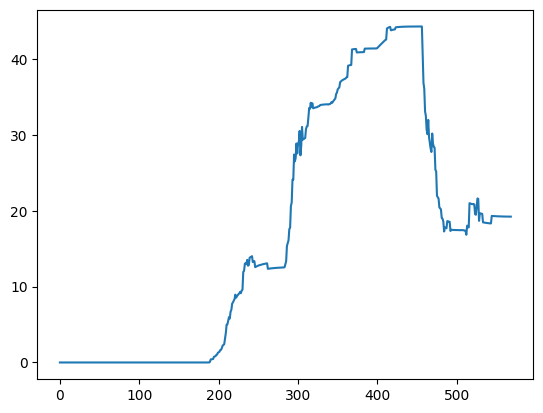

In [38]:
h,q_us,q_ds,q_w = [pred[...,i] for i in range(4)]
plt.plot(((q_us + r[...,0] - q_ds).clip(0) * ((hmax-h)<0.1))[:,0,:].mean(axis=1))

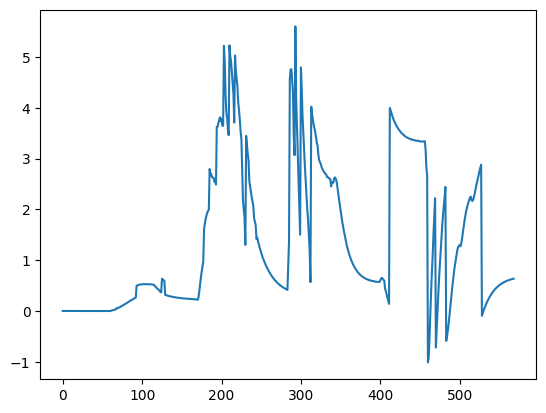

In [41]:
h,q_us,q_ds,q_w = [true[...,i] for i in range(4)]
plt.plot((q_us+r[...,-1]-q_ds-q_w)[:,0,:].mean(axis=1))

In [14]:
pred.shape

(569, 5, 105, 4)

In [17]:
hmax.shape

(105,)

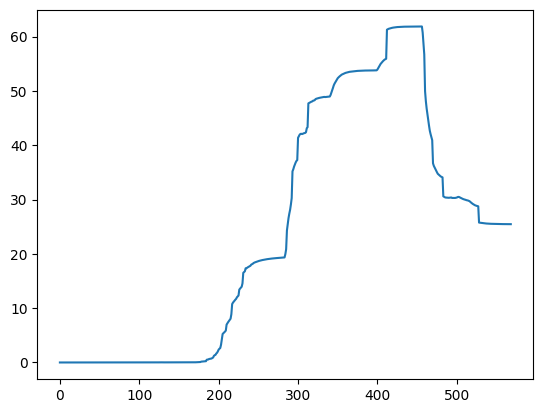

In [31]:
h,q_us,q_ds,q_w = [true[...,i] for i in range(4)]
plt.plot(((q_us + r[...,0] - q_ds).clip(0) * ((hmax-h)<0.01))[:,0,:].mean(axis=1))

## Train loss

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
cwd = './model/shunqing/10s_10k_res_norm_bal_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

In [5]:
train_ids

array([108,  55,   3,  43, 146,  19, 125,   3, 135,  58,   1,  71,  26,
        78, 130,  76,  54, 111, 123, 121,  99, 135, 141, 130,   5, 124,
         6,  25,  50, 127,   6,   2, 104,  77,  86, 141, 116,  18,  13,
        76,  91,  12, 123, 130,  19,  64,  72,  96,  77,  67,   3,  68,
        29,   7, 122,  76, 127,  14,  11,  55,  46,  91,  20, 124,  89,
        31,   7,  23,  80,   6,  46,  20,  69, 137,  77, 100,   5,  37,
         7,  22,  96,  79, 108,  90,  97,  38, 130, 133,  33, 118,  88,
       101,  79,  48, 142, 122,  84,  38,  98,  66, 132,  74,  18,  87,
        33,  38,  33,  26,   0,  41,  95,  68,  69,  58, 119,  53,  81,
       121])

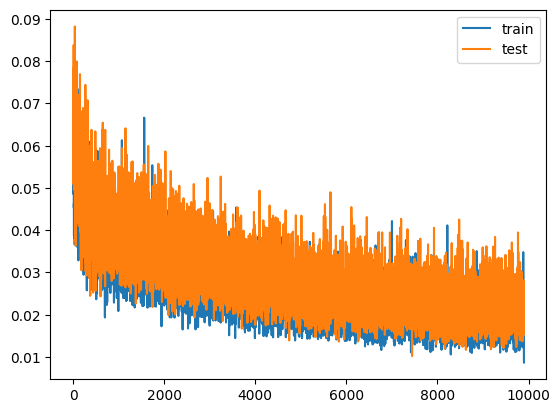

In [10]:
plt.plot(train_losses[100:],label='train')
plt.plot(test_losses[100:],label='test')
plt.legend()

# RedChicoSur

## Prediction

In [254]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [384]:
cwd = './results/RedChicoSur/5s_10k_out_edge_res_norm_flood_bal/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [385]:
from utilities import get_inp_files
from envs import get_env
env = get_env('RedChicoSur')()
train_id = np.load('./model/RedChicoSur/5s_10k_edge_res_norm_flood_bal/train_id.npy')
events = get_inp_files(env.config['swmm_input'],env.config['rainfall'])
[event for idx,event in enumerate(events) if idx not in train_id]

['./envs/network/RedChicoSur/eval_0.inp',
 './envs/network/RedChicoSur/test_3.inp',
 './envs/network/RedChicoSur/train_16.inp',
 './envs/network/RedChicoSur/train_19.inp',
 './envs/network/RedChicoSur/train_5.inp',
 './envs/network/RedChicoSur/train_8.inp']

### Nodes

In [386]:
event = 'train_0'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred
err.shape

(342, 5, 443, 6)

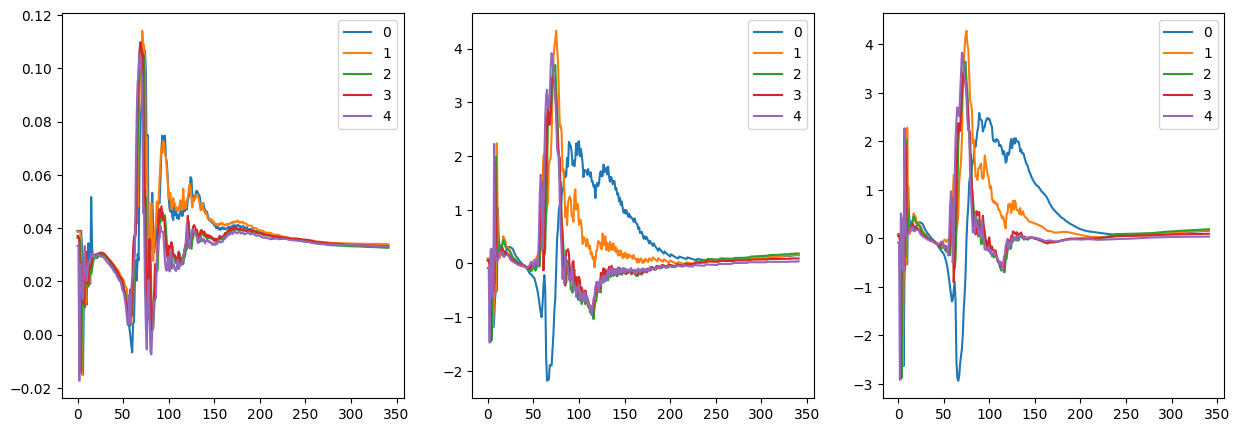

In [409]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(5):
        ax.plot(pred.mean(axis=2)[:,j,i]-true.mean(axis=2)[:,j,i],label=j)
    ax.legend()

In [388]:
import pandas as pd
rmse = pd.DataFrame(columns=['depth','inflow','outflow','flood'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((np.concatenate([pred[:,j,...,:3],pred[:,j,...,-1:]],axis=-1).mean(axis=1) - np.concatenate([true[:,j,...,:3],true[:,j,...,-1:]],axis=-1).mean(axis=1))**2).mean(axis=0))
rmse

,depth,inflow,outflow,flood
0,0.040250,0.873110,1.041775,0.068532
1,0.041414,0.785833,0.818367,0.068317
2,0.036170,0.684601,0.645295,0.068185
3,0.036831,0.672475,0.642426,0.068074
4,0.035075,0.737658,0.694270,0.068245


Text(0.5, 1.0, 'Flooding')

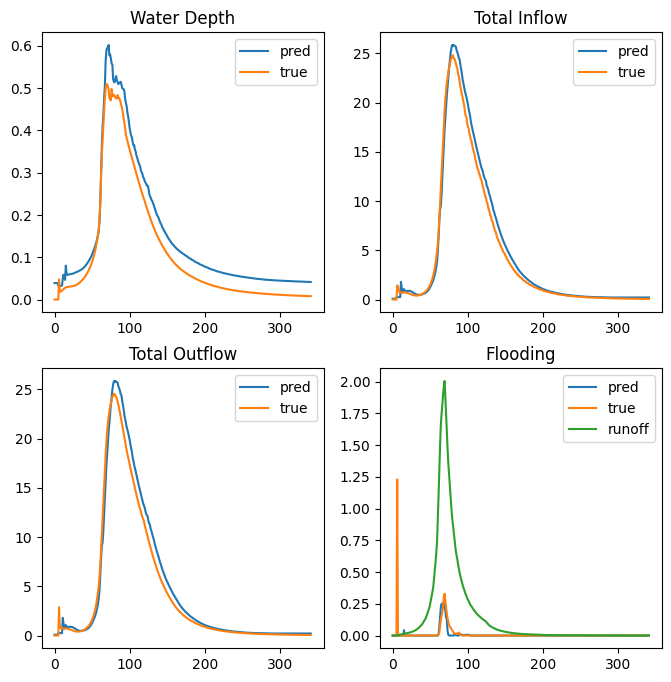

In [389]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = 0


ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

In [397]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.OUTFALLS)]
idx = nodes.index('DESC')

In [398]:
import pandas as pd
rmse = pd.DataFrame(columns=['depth','inflow','outflow','flood'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((np.concatenate([pred[:,j,idx,:3],pred[:,j,idx,-1:]],axis=-1) - np.concatenate([true[:,j,idx,:3],true[:,j,idx,-1:]],axis=-1))**2).mean(axis=0))
rmse

,depth,inflow,outflow,flood
0,0.094104,18.272484,0.0,0.0
1,0.125275,12.568685,0.0,0.0
2,0.160671,13.202897,0.0,0.0
3,0.151943,11.413598,0.0,0.0
4,0.160711,13.317207,0.0,0.0


Text(0.5, 1.0, 'Flooding')

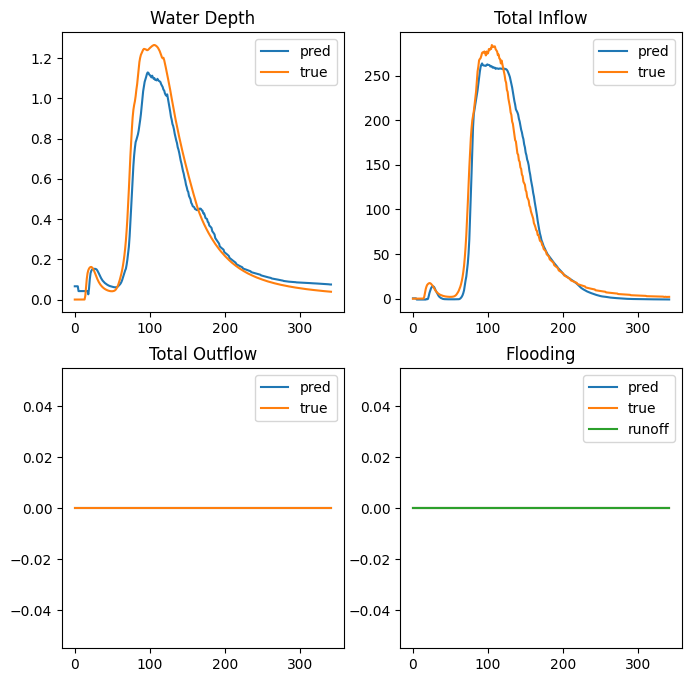

In [399]:
seq = 0

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

### Edge

In [371]:
event = 'train_0'
true = np.load(os.path.join(cwd,event+'_edge_true.npy'))
pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
err = true - pred
err.shape

(342, 5, 444, 3)

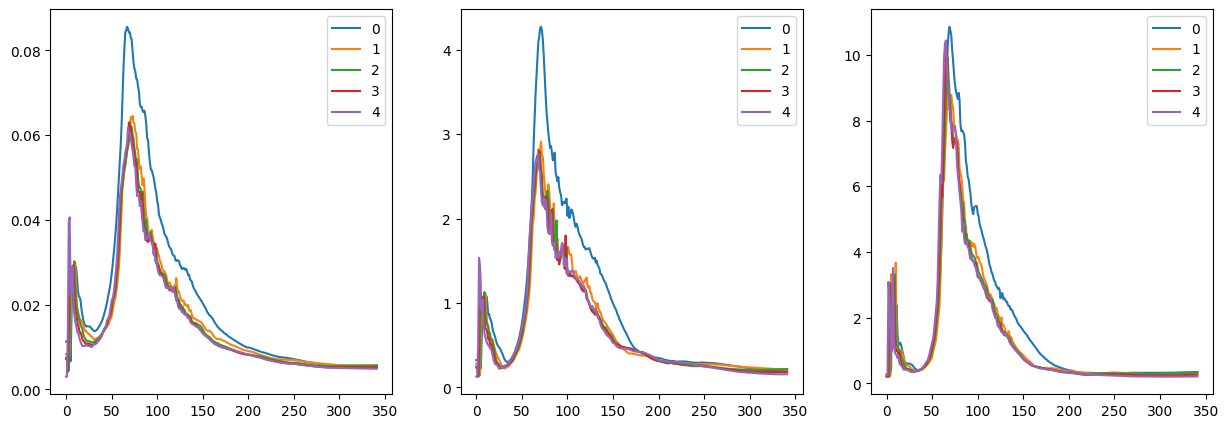

In [372]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

In [373]:
import pandas as pd
rmse = pd.DataFrame(columns=['volume','depth','flow'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((pred[:,j,...].mean(axis=1) - true[:,j,...].mean(axis=1))**2).mean(axis=0))
rmse

,volume,depth,flow
0,0.015238,0.763456,1.052878
1,0.005981,0.249579,0.851586
2,0.005479,0.216055,0.664801
3,0.005317,0.219031,0.666870
4,0.005343,0.203722,0.717945


Text(0.5, 1.0, 'Link flow')

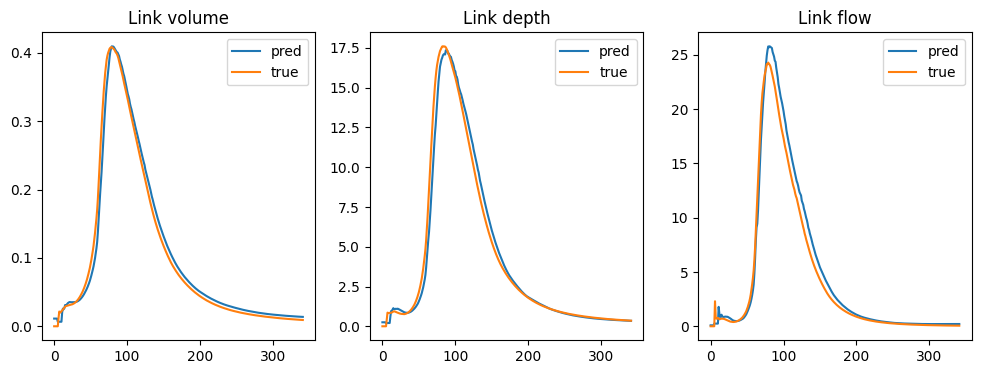

In [376]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))
seq = 0

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Link flow')


In [366]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
links = [k for k in list(inp.CONDUITS)+list(inp.ORIFICES)]
idx = links.index('PLT85829')


In [367]:
import pandas as pd
rmse = pd.DataFrame(columns=['volume','depth','flow'])
for j in range(err.shape[1]):
    rmse.loc[j] = np.sqrt(((pred[:,j,idx,:] - true[:,j,idx,:])**2).mean(axis=0))
rmse

,volume,depth,flow
0,0.005736,0.139045,0.723163
1,0.005546,0.151490,0.690023
2,0.005443,0.138685,0.575955
3,0.005607,0.141368,0.603329
4,0.005650,0.147148,0.612273


Text(0.5, 1.0, 'Link flow')

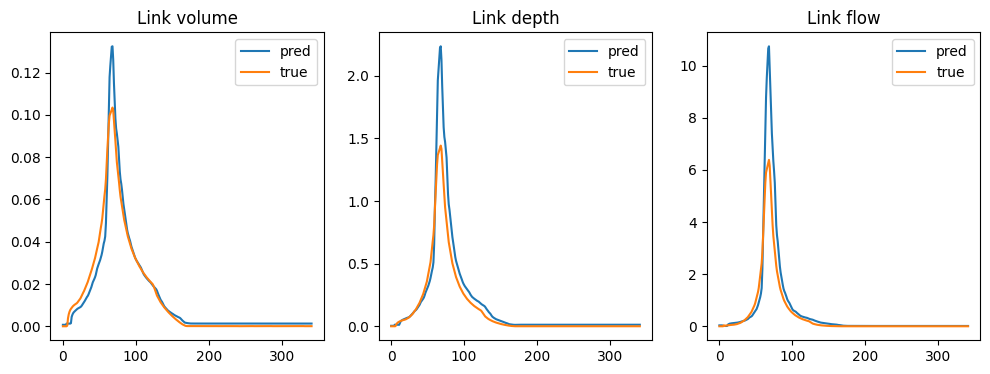

In [369]:
seq = 0

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Link volume')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Link depth')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Link flow')



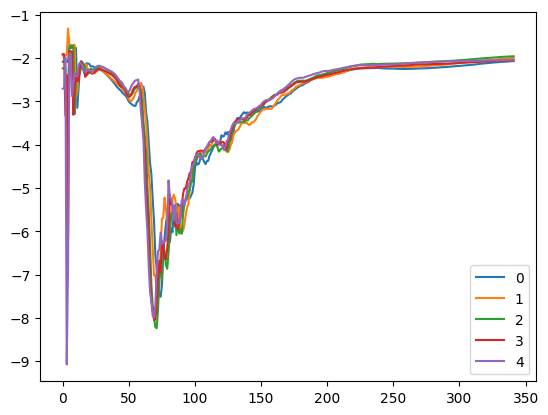

In [94]:
# debug node-edge balance loss
from envs import get_env
from numpy import matmul
event='train_0'
edge_pred = np.load(os.path.join(cwd,event+'_edge_pred.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))

env = get_env('RedChicoSur')()
env_args = env.get_args()
err = matmul(np.abs(env_args['node_edge']),edge_pred[...,-1:]) - pred[...,1:2] - pred[...,2:3]
for j in range(err.shape[1]):
    plt.plot(err.mean(axis=2)[:,j],label=j)
plt.legend()

## Training

In [95]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [96]:
cwd = './model/RedChicoSur/5s_5k_edge_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

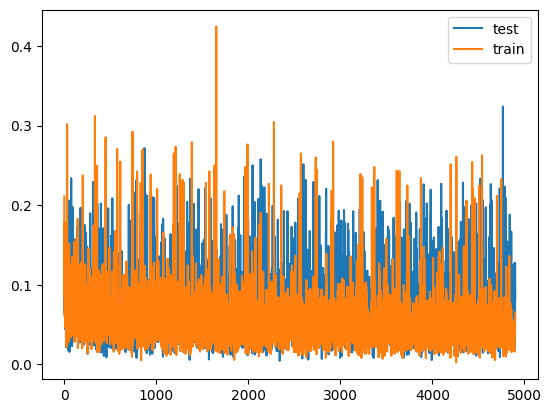

In [98]:
plt.plot(test_losses[100:].sum(axis=1),label='test')
plt.plot(train_losses[100:],label='train')
plt.legend()

# astlingen

In [37]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [38]:
cwd = './results/astlingen/10s_act_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [39]:
event = 'astlingen_08_21_2001_08'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred

In [40]:
true.shape

(542, 10, 29, 6)

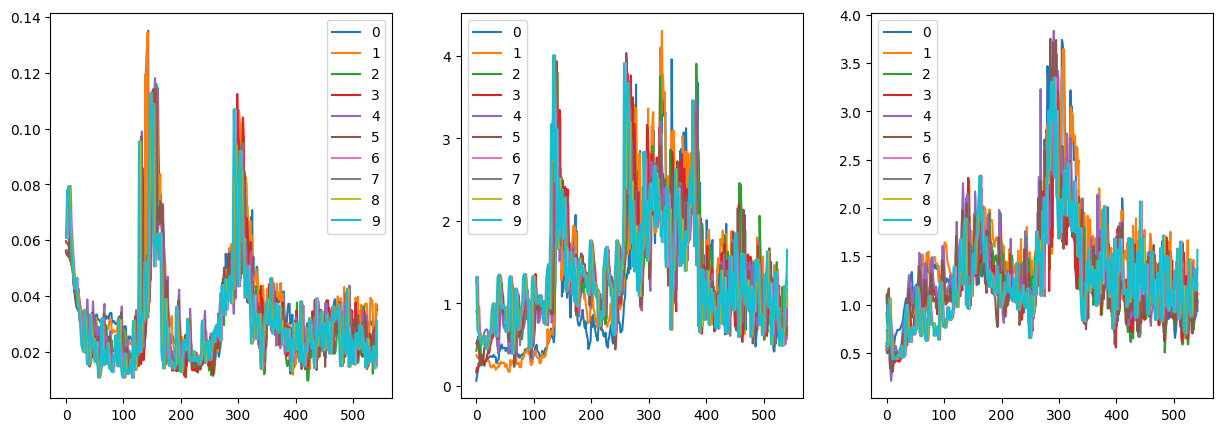

In [41]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

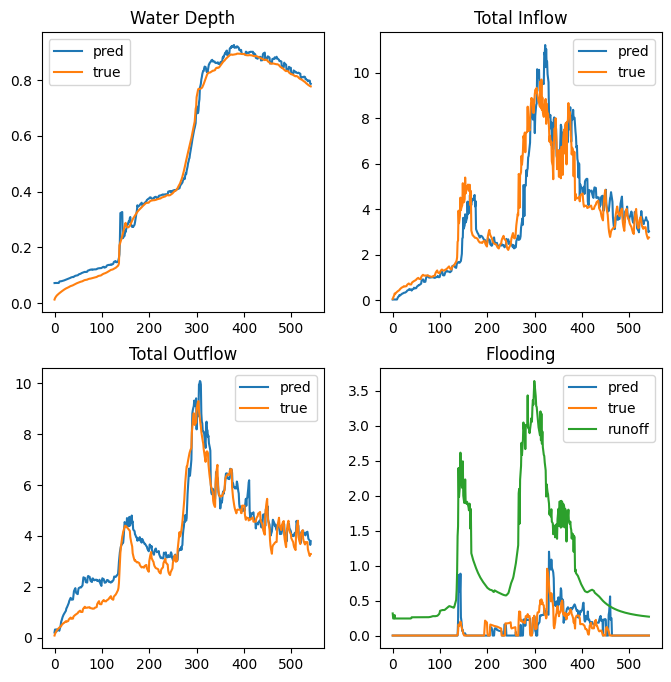

In [42]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = 0

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

In [43]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/astlingen/astlingen.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.STORAGE)]

Text(0.5, 1.0, 'Flooding')

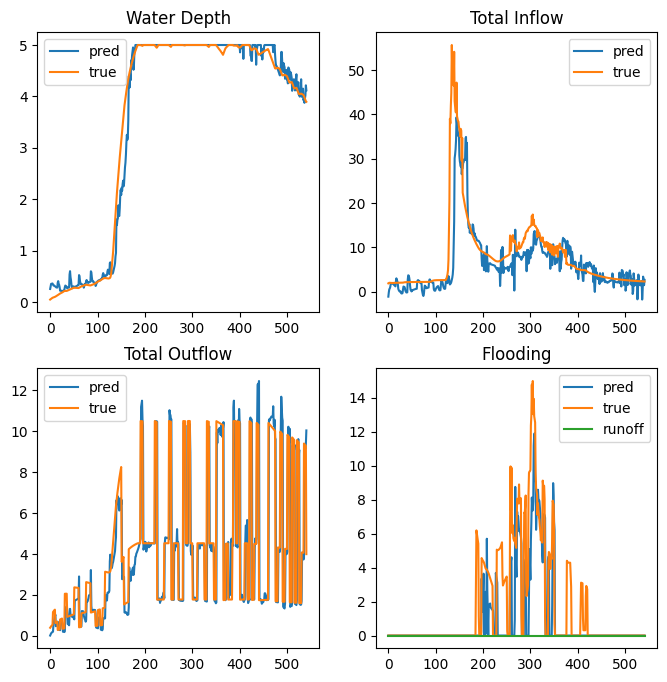

In [46]:
idx = nodes.index('T6')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')